# Travelling Salesman
## Genetic Algorithm

In this project, we solve the Travelling Salesman problem, using genetic algorithm. We create a map of cities, a evolutionary agent in the form of our salesman, and compare our results to a brute force approach. Along the way, we do some nice optimisations, then visualise the result. There are notes on the cool stuff below.

### Creating a Grid of Cities

**Measuring Distance**
* It's good to avoid **sqrt()** for computational efficiency, we can use a relative distance measure instead.
* To avoid repeatedly calculating the distance between 2 cities, we can store it in a cache initially.
* Distance from *a* to *b* is the same as from *b* to *a*, so we avoid storing these duplicates.

**Getting The Right Answer**
* We can try all paths from city to city, to see which is the shortest.
* With Heap's Algorithm we brute force all permuations in **O(n!)** time, the fastest possible.
* Then we just sum up the precomputed distances between each city in each permutation and save the smallest trip.

**Making Things Look Nice**
* Printing the memory location for custom classes is not very useful.
* We overwrite the **str()** method with a cool visual representation of the grid.

In [2]:
def heaps_algo(seq, length):
  if length == 1:  # Base case.
    yield seq
    return
  for i in range(length):
    yield from heaps_algo(seq, length - 1)  # Length decrements on each call.
    if length & 1:  # If length is even.
      seq[0], seq[length - 1] = seq[length - 1], seq[0]  # Swap first and last.
    else:
      seq[i], seq[length - 1] = seq[length - 1], seq[i]  # Swap current and last.

In [3]:
from random import randint, random


class City:
  def __init__(self, name, pop, pos):
    self.name = name
    self.pop = pop
    self.x = pos[0]
    self.y = pos[1]

  def __str__(self):
    return f"Name: {self.name}, Pos: ({self.x}, {self.y}), Pop: {self.pop}"


class CityMap:
  def __init__(self, num_cities, grid_size):
    self.grid_size = grid_size
    self.cities = self.gen_cities(num_cities, grid_size)
    self.dist_cache = self.cache_distance()  # Pre-computed distances.

  def gen_cities(self, num_cities, grid_size):
    chosen = set()  # Positions that are already taken.
    cities = []
    num = 0
    while len(cities) < num_cities:  # Won't be too many cities so this is fine.
      pos = (randint(0, grid_size[0]-1), randint(0, grid_size[1]-1))
      if pos not in chosen:  # Consider time complexity when calling "in".
        chosen.add(pos)
        cities.append(City(num, random(), pos))
        num += 1
    return cities

  def get_cities_coordinates(self):
    return [[city.x, city.y] for city in self.cities]

  def calc_dist(self, city_a_ind, city_b_ind):
    x_diff = self.cities[city_a_ind].x - self.cities[city_b_ind].x
    y_diff = self.cities[city_a_ind].y - self.cities[city_b_ind].y
    return abs(x_diff) + abs(y_diff)  # Relative dist is all that matters.

  def cache_distance(self):
    cache = {}
    for i in range(len(self.cities)):
      for j in range(i+1, len(self.cities)):  # Don't want (1,2) and (2,1) or (2,2) so start at i+1.
        cache[(i, j)] = self.calc_dist(i, j)
    return cache

  def get_cached_dist(self, i, j):
    if (i, j) in self.dist_cache:
      return self.dist_cache[(i, j)]
    if (j, i) in self.dist_cache:  # Also search for reversed. Saves having to actually store it!
      return self.dist_cache[(j, i)]
    raise IndexError(f"Neither {(i, j)} not {(j, i)} in dist_cache!")

  def get_path_dist(self, path):
    tot_dist = 0
    for i in range(1, len(path)):
      tot_dist += self.get_cached_dist(path[i - 1], path[i])
    return tot_dist

  def gen_brute_force(self):
    best_dist = float("Inf")
    best_path = []
    cities_seq = list(range(len(self.cities)))
    perms_generator = heaps_algo(cities_seq, len(self.cities))  # Generate all possible paths.
    for path_perm in perms_generator:
      tot_dist = self.get_path_dist(path_perm)
      if tot_dist < best_dist:  # Update new best path and distance.
        best_dist = tot_dist
        best_path = path_perm.copy()
    return best_path

  def __str__(self):
    lst = [[" . "] * self.grid_size[1] for _ in range(self.grid_size[0])]
    for city in self.cities:
      lst[city.x][city.y] = " " + str(city.name) + " "
    output = []
    for line in lst:
      output += line + ["\n"]
    return "".join(output)


# Creating An Evolutionary Agent

**Fitness**
* Shorter path is better, or more "fit". Simply invert path length, so short paths give high fitness.
* Set minimum fitness, will be used in division so it can't be zero.

**Crossover**
* Take first **x** cities in first parent's path to form child's path.
* Fill remaining cities using a sequence from the second parent's path.
* Be careful not to take repeat cities.
* Checking membership in a collection is **O(1)** for **set** but **O(n)** for **list**.

**Mutation**
* If the genetic info (path) of all parents is bad, we're stuck!
* Can use random mutation of the child path to solve this, by swapping cities in the path.
* For each city in the child's path, mutate it with a given probability.

In [4]:
from random import random, randint
from numpy.random import choice


class Salesman:
  def __init__(self, city_map):
    self.path = choice(len(city_map.cities), len(city_map.cities), replace=False).tolist()
    self.fitness_lower_bound = 0.000005  # Everything has a fitness of at least this minimum level.
    self.fitness = self.fitness_lower_bound
    self.city_map = city_map

  def calc_fitness(self):
    tot_dist = self.city_map.get_path_dist(self.path)
    fitness = 1 / (tot_dist + 1)  # Shorter distance is better, so invert.
    self.fitness = max(self.fitness_lower_bound, fitness)

  def crossover(self, other_parent):
    path_len = len(self.path)
    if len(self.path) != len(other_parent.path):
      msg = f"Child must have genes of same length as Parent! ({len(other_parent.path)} Vs {path_len})"
      raise ValueError(msg)
    start = randint(0, path_len)
    end = randint(min(start+1, path_len), path_len)  # Maintain the order of parent's path.
    new_path = self.path[start:end+1]  # Initially take chunk of first parent.
    new_path_members = set(new_path)  # Loop is O(n) so O(1) membership check makes sense.
    for item in other_parent.path:  # Build remaining path.
      if item not in new_path_members:  # O(1) membership check in set.
        new_path_members.add(item)  # A bit messy appending to two things but O(1) each, so worth it.
        new_path.append(item)
        if len(new_path) >= path_len:
          break
    child = Salesman(self.city_map)
    child.path = new_path
    return child

  def attempt_mutation(self, mutation_probability):
    if 0 > mutation_probability > 1:
      raise ValueError("The mutation_probability must be between 0 and 1!")
    for i in range(len(self.path)):  # TODO: Could swap two *neighbours* instead.
      if mutation_probability > random():
        rand_pos = randint(0, len(self.path)-1)  # Random index to swap with.
        self.path[i], self.path[rand_pos] = self.path[rand_pos], self.path[i]


### Creating An Evolutionary Environment

**Roulette Wheel Sampling**
* 2 parents must be selected from the mating pool and parents with higher fitness should be selected more often.
* The fitter the parent, the more space it occupies on a "roulette wheel" *i.e.* the larger its interval.
* We generate a random number, and return the parent whose interval the number fits in.
* We find the interval using binary search, in **O(logn)** time.

**Reproduction**
* Evolution requires combining elements of both parents, *i.e.* crossover.
* During crossover, a random mutation can occur.
* The child resulting from this process is added to the next generation.

**Evolution**
* Looping process: Reproduce -> Calculate Fitness -> Update Best Path -> Check if Finished.
* Finished if a child reaches a threshold target fitness level, or at a max number of generations (iterations).

In [5]:
from random import uniform
from salesman import Salesman


class Environment:
  def __init__(self, evo_setup):
    self.population = [Salesman(evo_setup["city_map"]) for _ in range(evo_setup["pop_size"])]
    self.mutation_probability = evo_setup["mutation_prob"]
    self.best = self.population[0]
    self.finished = False
    self.generation = 0
    self.target_fitness = evo_setup["target_fitness"]
    self.max_gens = evo_setup["max_gens"]
    self.best_salesmen = []

  def calc_pop_fitness(self):
    for salesman in self.population:
      salesman.calc_fitness()

  def update_best(self):
    for salesman in self.population:
      if salesman.fitness > self.best.fitness:  # New best salesman.
        self.best = salesman
      if salesman.fitness >= self.target_fitness:  # Terminate if target fitness already achieved.
        self.finished = True

  def roulette_sample(self):

    #  Get probability intervals:
    total_weight = sum(salesman.fitness for salesman in self.population)
    rel_weight = [salesman.fitness / total_weight for salesman in self.population]
    for i in range(1, len(rel_weight)):
      rel_weight[i] = rel_weight[i] + rel_weight[i - 1]

    #  Binary search the interval random num fits in:
    random_num = uniform(0, rel_weight[-1])
    left, right = 0, len(rel_weight)
    while left < right:
      mid = (left + right) // 2
      if random_num > rel_weight[mid]:
        left = mid + 1
      else:
        right = mid
    return self.population[left]

  def reproduce(self):
    next_generation = []
    for _ in range(len(self.population)):
      parent_a = self.roulette_sample()
      parent_b = self.roulette_sample()
      child = parent_a.crossover(parent_b)
      child.attempt_mutation(self.mutation_probability)
      next_generation.append(child)  # Can't add child to pop we're sampling from.
    self.population = next_generation.copy()

  def display(self):
    print(f"[Gen {self.generation}] Best: '{self.best.path}' Score: {self.best.fitness}")

  def sim(self):
    while not self.finished:
      self.update_best()
      self.reproduce()
      self.calc_pop_fitness()
      self.best_salesmen.append(self.best)
      self.generation += 1
      if self.max_gens and self.generation > self.max_gens:
        self.finished = True


# Results

**The Best Path**
* We expect the evolution method to find the same length path as the brute force method.
* Genetic Algorithm is not deterministic though, so finding the best result is not guaranteed.
* There may be multiple paths with the optimal length.

In [6]:
import matplotlib.pyplot as plt


def plot_cities(city_map):
  cities_x = [city.x for city in city_map.cities]
  cities_y = [city.y for city in city_map.cities]
  colours = ["yellow"] * len(cities_x)
  colours[0] = "green"
  colours[-1] = "red"
  _, ax = plt.subplots()
  ax.grid(zorder=0)
  ax.scatter(cities_x, cities_y, s=350, zorder=3, color=colours)
  for i in range(1, len(cities_x)):
    from_loc = (cities_x[i], cities_y[i])
    to_loc = (cities_x[i-1], cities_y[i-1])
    plt.annotate(text=f"{i}", xy=from_loc, xytext=to_loc, arrowprops=dict(arrowstyle="->"))
  plt.annotate(text=f"{len(cities_x)}", xy=(cities_x[-1], cities_y[-1]))
  plt.show()

def plot_fitness(best_salesmen):
  generation = range(len(best_salesmen))
  fitness = [salesman.fitness for salesman in best_salesmen]
  _, ax = plt.subplots()
  ax.plot(generation, fitness)
  ax.set(xlabel="Generation", ylabel="Fitness", title="Salesman Fitness")
  ax.grid()
  plt.show()


# Running The Simulation

In [7]:
evo_setup = {
  "city_map": CityMap(8, (10, 10)),
  "pop_size": 250,
  "mutation_prob": 0.2,
  "target_fitness": 1,
  "max_gens": 100
}

In [8]:
environment = Environment(evo_setup)
environment.sim()
best_path_sim = environment.best.path
best_path_sim_dist = evo_setup["city_map"].get_path_dist(best_path_sim)

In [9]:
best_path_bf = evo_setup["city_map"].gen_brute_force()
best_path_bf_dist = evo_setup["city_map"].get_path_dist(best_path_bf)

In [10]:
print(f"[Brute Force] Path: {best_path_bf} with length: {best_path_bf_dist}")
print(f"[Genetic Algorithm] Path: {best_path_sim} with length: {best_path_sim_dist}")

[Brute Force] Path: [4, 0, 7, 2, 1, 5, 6, 3] with length: 24
[Genetic Algorithm] Path: [4, 0, 7, 2, 1, 5, 6, 3] with length: 24


In [21]:
plt.rcParams['figure.figsize'] = [16, 8] # Increase matplotlib plot size.S

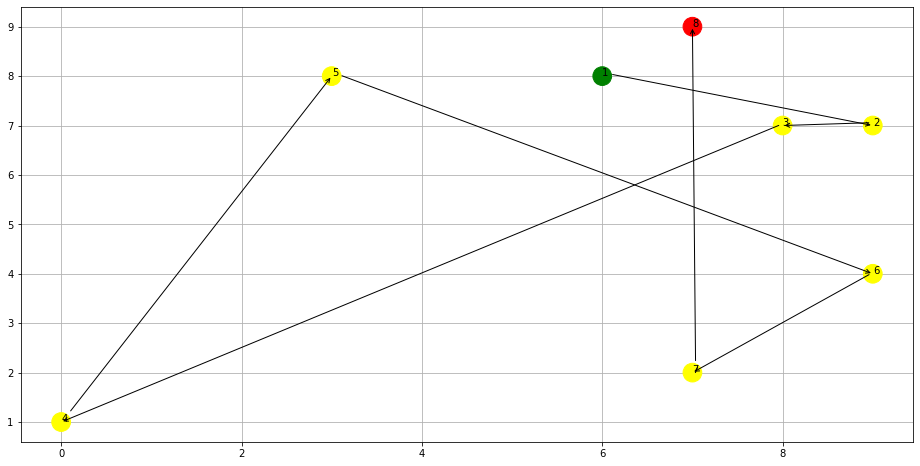

In [22]:
plot_cities(evo_setup["city_map"])

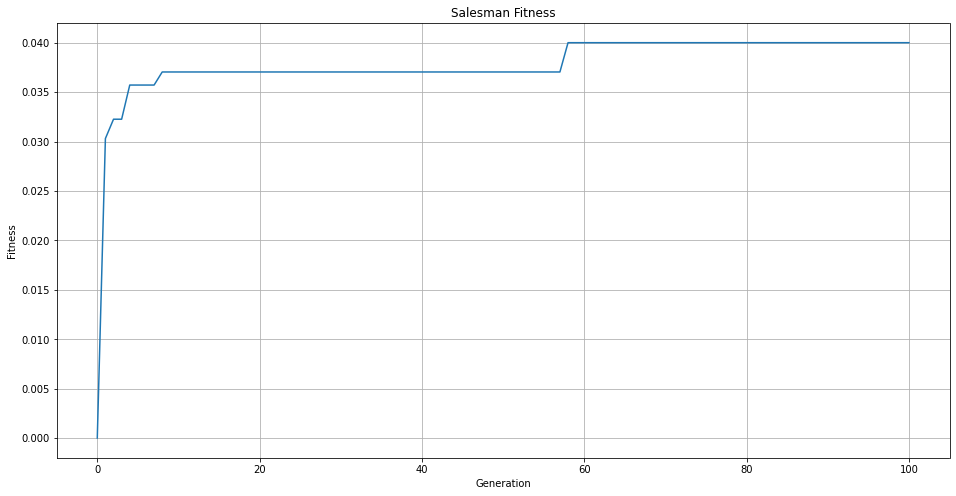

In [23]:
plot_fitness(environment.best_salesmen)